# **IMPORTING** **LIBRARIES**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row, SQLContext
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
# Create a SparkSession
spark = SparkSession.builder.appName('YourAppName').getOrCreate()

In [ ]:
from pyspark.ml.feature import StringIndexer

df = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])

indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed = indexer.fit(df).transform(df)
indexed.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+



In [ ]:
spark = SparkSession.builder.appName('spotifyAnalysis').getOrCreate()

In [ ]:
rawDF =spark.read.options(mode='FAILFAST',
                              header = True,
                              multiLine=True,
                              inferSchema=True,
                              escape='"').csv("/content/sample_data/dataset_Spotify.csv")

In [ ]:
rawDF.show(15)

+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+
|_c0|            track_id|             artists|          album_name|          track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|track_genre|
+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+
|  0|5SuOikwiRyPMVoIQD...|         Gen Hoshino|              Comedy|              Comedy|        73|     230666|   false|       0.676| 0.461|  1|  -6.746|   0|      0.143|      0.0322|         1.01E-6|   0.358|  0.715| 87.917|            

In [ ]:
rawDF.printSchema();

root
 |-- _c0: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- track_genre: string (nullable = true)



In [ ]:
# Define the columns to keep
columns_to_keep = [
    "artists", "album_name", "track_name", "popularity",
    "duration_ms", "explicit", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "track_genre"
]

# Select only the desired columns
cleanedDF = rawDF.select(columns_to_keep)

# Verify the schema after selection
cleanedDF.printSchema()

root
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- track_genre: string (nullable = true)



In [ ]:
cleanedDF.show(15)

+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|             artists|          album_name|          track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|track_genre|
+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|         Gen Hoshino|              Comedy|              Comedy|        73|     230666|   false|       0.676| 0.461|  1|  -6.746|   0|      0.143|      0.0322|         1.01E-6|   0.358|  0.715| 87.917|   acoustic|
|        Ben Woodward|    Ghost (Acoustic)|    Ghost - Acoustic|        55|     149610|   false|        0.42| 0.166|  1| -17.235|   1|     0.076

## **DATA CLEANING**

In [ ]:
# Check for null values in each column
cleanedDF.select([F.count(F.when(F.isnull(F.col(c)), 1)).alias(c) for c in cleanedDF.columns]).show()

+-------+----------+----------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|artists|album_name|track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|track_genre|
+-------+----------+----------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+
|      1|         1|         1|         0|          0|       0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|
+-------+----------+----------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+



In [ ]:
# Drop rows with null values (if needed)
cleanedDF = cleanedDF.dropna()

## **DATA EXPLORATION**

In [ ]:
from pyspark.sql.functions import col

# Group by 'artists' column and count the occurrences
top_artists = (
    cleanedDF.groupBy("artists")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)

# Show the top 10 artists
top_artists.show()


+---------------+-----+
|        artists|count|
+---------------+-----+
|    The Beatles|  279|
|   George Jones|  271|
|  Stevie Wonder|  236|
|    Linkin Park|  224|
|Ella Fitzgerald|  222|
|  Prateek Kuhad|  217|
|           Feid|  202|
|    Chuck Berry|  190|
|Håkan Hellström|  183|
|    OneRepublic|  181|
+---------------+-----+



In [ ]:
# Extract top artist names as a list
top_artist_names = [row["artists"] for row in top_artists.collect()]

# Filter the DataFrame for these artists
top_artist_tracks = rawDF.filter(col("artists").isin(top_artist_names))


In [ ]:
from pyspark.sql.functions import avg

# Calculate average popularity for each of the top 10 artists
popularity_analysis = (
    top_artist_tracks.groupBy("artists")
    .agg(avg("popularity").alias("avg_popularity"))
    .orderBy(col("avg_popularity").desc())
)

# Show the results
popularity_analysis.show()


+---------------+------------------+
|        artists|    avg_popularity|
+---------------+------------------+
|    The Beatles|61.007168458781365|
|    Linkin Park| 56.07142857142857|
|  Prateek Kuhad| 46.33179723502304|
|Håkan Hellström| 31.48633879781421|
|    OneRepublic|30.861878453038674|
|   George Jones|16.505535055350553|
|           Feid|10.084158415841584|
|    Chuck Berry| 7.873684210526315|
|  Stevie Wonder|1.0635593220338984|
|Ella Fitzgerald|0.7342342342342343|
+---------------+------------------+



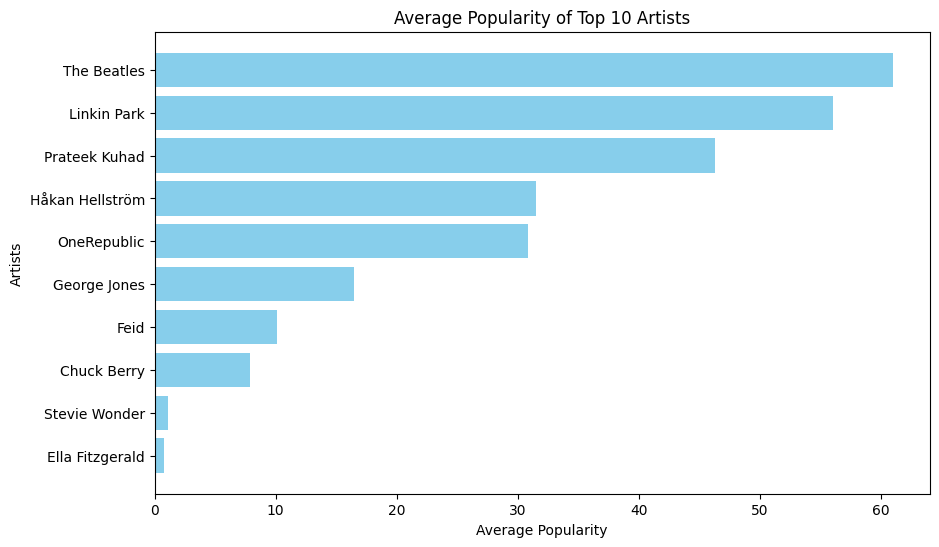

In [ ]:
# Convert the result to Pandas DataFrame for visualization
popularity_pd = popularity_analysis.toPandas()

import matplotlib.pyplot as plt

# Create a bar plot for the average popularity of top 10 artists
plt.figure(figsize=(10, 6))
plt.barh(popularity_pd['artists'], popularity_pd['avg_popularity'], color='skyblue')
plt.xlabel('Average Popularity')
plt.ylabel('Artists')
plt.title('Average Popularity of Top 10 Artists')
plt.gca().invert_yaxis()  # To have the highest popularity on top
plt.show()


+-----------+--------------+
|track_genre|avg_popularity|
+-----------+--------------+
|   pop-film|        59.283|
|      k-pop|        56.896|
|      chill|        53.651|
|        sad|        52.379|
|     grunge|        49.594|
|     indian|        49.539|
|      anime|        48.772|
|        emo|        48.128|
|  sertanejo|        47.866|
|        pop|        47.576|
+-----------+--------------+



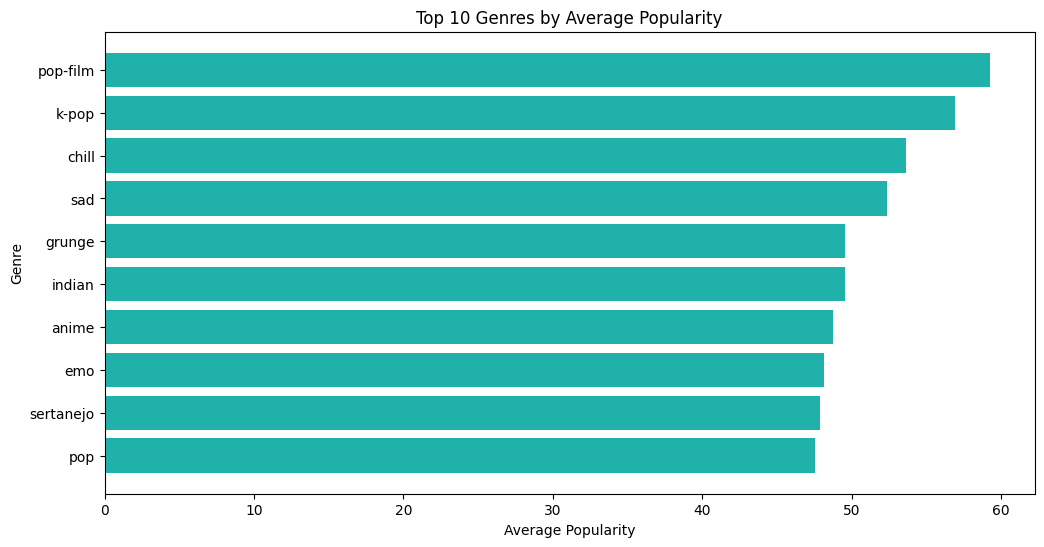

In [ ]:
from pyspark.sql.functions import col, avg

# Group by genre, calculate average popularity, and limit to top 10 genres
top_10_genres = (
    rawDF.groupBy("track_genre")
    .agg(avg("popularity").alias("avg_popularity"))
    .orderBy(col("avg_popularity").desc())
    .limit(10)
)

# Show the top 10 genres with their average popularity
top_10_genres.show()


import matplotlib.pyplot as plt

# Convert the result to Pandas DataFrame for visualization
top_10_genres_pd = top_10_genres.toPandas()

# Create a bar plot for the top 10 genres by average popularity
plt.figure(figsize=(12, 6))
plt.barh(top_10_genres_pd['track_genre'], top_10_genres_pd['avg_popularity'], color='lightseagreen')
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average Popularity')
plt.gca().invert_yaxis()  # To have the highest popularity on top
plt.show()

## **CORRELATION**

In [ ]:
cleanedDF.show()

+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|             artists|          album_name|          track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|track_genre|
+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|         Gen Hoshino|              Comedy|              Comedy|        73|     230666|   false|       0.676| 0.461|  1|  -6.746|   0|      0.143|      0.0322|         1.01E-6|   0.358|  0.715| 87.917|   acoustic|
|        Ben Woodward|    Ghost (Acoustic)|    Ghost - Acoustic|        55|     149610|   false|        0.42| 0.166|  1| -17.235|   1|     0.076

In [ ]:
from pyspark.sql.functions import col, corr

# Drop unnecessary columns (assuming they are already identified)
df_filtered = cleanedDF.drop("artists", "album_name", "track_name", "track_genre")
df_filtered.show()

+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+
|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+
|        73|     230666|   false|       0.676| 0.461|  1|  -6.746|   0|      0.143|      0.0322|         1.01E-6|   0.358|  0.715| 87.917|
|        55|     149610|   false|        0.42| 0.166|  1| -17.235|   1|     0.0763|       0.924|         5.56E-6|   0.101|  0.267| 77.489|
|        57|     210826|   false|       0.438| 0.359|  0|  -9.734|   1|     0.0557|        0.21|             0.0|   0.117|   0.12| 76.332|
|        71|     201933|   false|       0.266|0.0596|  0| -18.515|   1|     0.0363|       0.905|         7.07E-5|   0.132|  0.143| 181.74|
|        82|     198853|   

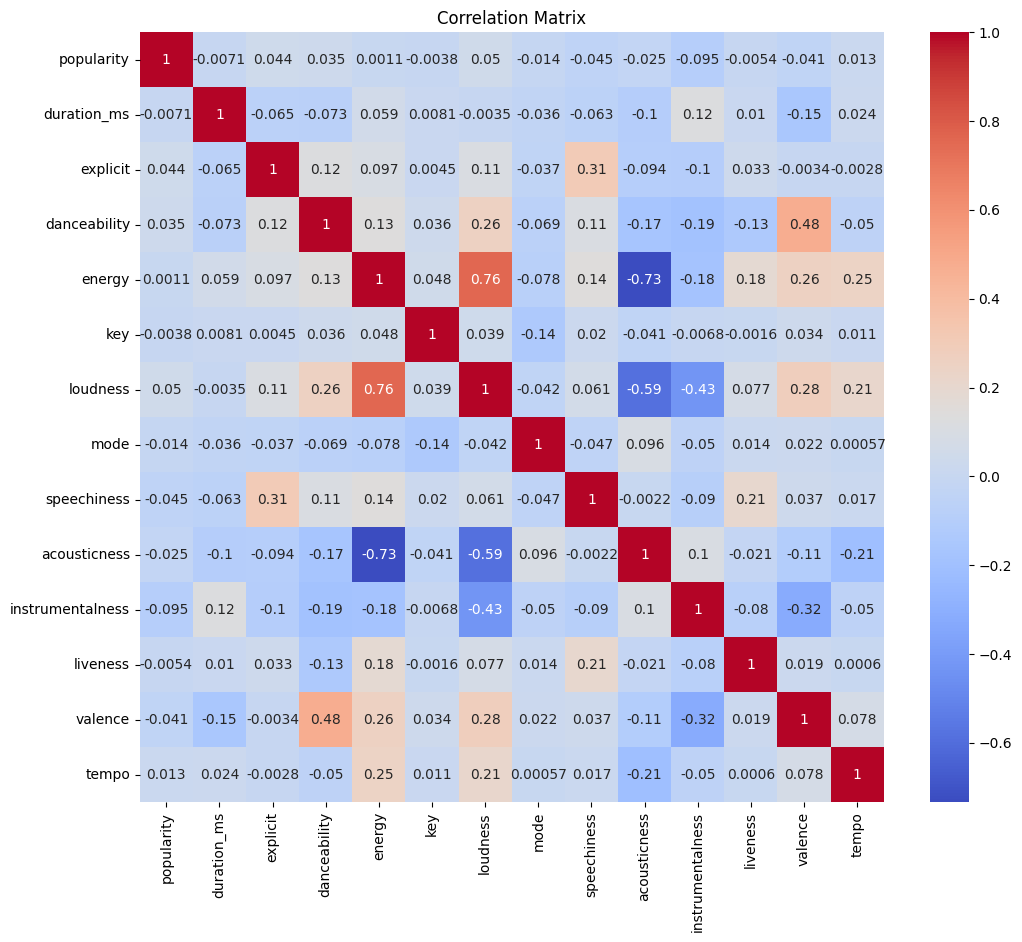

In [ ]:
pandas_df = df_filtered.toPandas()
correlation_matrix = pandas_df.corr()

# Create a heatmap using matplotlib or seaborn (assuming seaborn is available)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
# You might need to adjust how you pass the data to sns.heatmap for a single value
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## **Random Forest**

# Demonstrates a machine learning workflow to predict the "energy" feature using a Random Forest Regressor. It includes data preparation, feature scaling, training-test split, model training, and evaluation using metrics like MAE, MSE, RMSE, and R². A scatter plot visualizes the model's performance by comparing actual vs. predicted values. The model achieves an R² of 0.82, indicating a very good fit.

Mean Absolute Error: 0.0678
Mean Squared Error: 0.0108
Root Mean Squared Error: 0.1039
R-squared: 0.8287


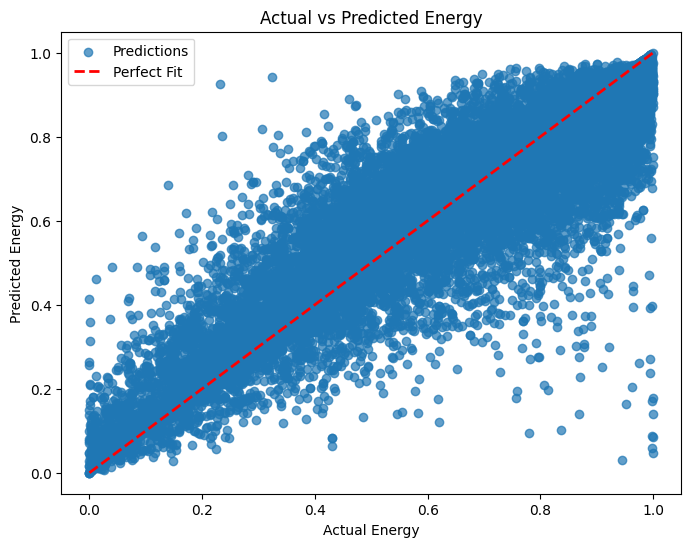

In [ ]:
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
cleanedDF_pandas = cleanedDF.toPandas()

# Select relevant features and target
X = cleanedDF_pandas[['tempo', 'key','loudness', 'acousticness', 'instrumentalness']]  # Input features
y = cleanedDF_pandas['energy']  # Target variable (Energy)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler to training data
X_test_scaled = scaler.transform(X_test)        # Transform test data

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
# Visualize the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Perfect Fit')
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")
plt.title("Actual vs Predicted Energy")
plt.legend()
plt.show()


## **NATURAL LANGUAGE PROCESSING**

In [ ]:
from pyspark.sql.functions import col

# Filter out rows where track_name or album_name is null
nlpDF = cleanedDF.select("track_name", "album_name","track_genre", "valence").dropna(subset=["track_name", "album_name","track_genre"])

# Show a sample
nlpDF.show(5, truncate=False)


In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import explode, col

# Tokenize track names with regex to include only words
regex_tokenizer = RegexTokenizer(inputCol="track_name", outputCol="tokens", pattern="\\W")
tokenizedDF = regex_tokenizer.transform(nlpDF)

# Remove stop words
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
filteredDF = stopwords_remover.transform(tokenizedDF)

# Aggregate and count token frequencies
keywordsDF = filteredDF.select(explode(col("filtered_tokens")).alias("keyword")) \
    .groupby("keyword").count().orderBy("count", ascending=False)

# Show top keywords
keywordsDF.show(10)


# Creates a word cloud visualization to represent the most frequently occurring keywords in track names. It uses a PySpark DataFrame to extract keyword frequencies, which are then passed to the WordCloud library to generate an engaging visual summary. The word cloud highlights prominent terms like "remix," "love," and "live," offering insights into the data's thematic content.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert keywords and their counts to a dictionary
keywords = {row['keyword']: row['count'] for row in keywordsDF.collect()}

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Track Names')
plt.show()


In [ ]:
!pip install transformers
!pip install torch

## **SENTIMENT ANALYSIS**

# It applies natural language processing to analyze the sentiment of track names using a Hugging Face Transformer model. By integrating a sentiment analysis pipeline, the notebook assigns sentiments (POSITIVE or NEGATIVE) to each track name. The results are stored in a new column, enabling a comparison between the sentiment scores and other features like valence. The analysis provides insights into the emotional tone of track names and their potential relationship with musical attributes.

In [ ]:
from transformers import pipeline

# Load a sentiment-analysis pipeline from Hugging Face
sentiment_pipeline = pipeline("sentiment-analysis")

# Define a function to get sentiment from Hugging Face model
def get_transformer_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']

# Apply the function as a UDF
transformer_sentiment_udf = F.udf(get_transformer_sentiment)
transformer_sentimentDF = nlpDF.withColumn("transformer_sentiment", transformer_sentiment_udf(col("track_name")))

transformer_sentimentDF.select("track_name", "transformer_sentiment", "valence").show(15, truncate=False)